# BOLD, non-BOLD, and TE-dependence with tedana


## Make figures and examples for dependence metric calculation

This notebook uses simulated T2*/S0 manipulations to show how TE-dependence is leveraged to denoise multi-echo data.

The equation for how signal is dependent on changes in S0 and T2*:

```{math}
:label: monoexponential_decay
S(t, TE_k) = \bar{S}(TE_k) * (1 + \frac{{\Delta}{S_0}(t)}{\bar{S}_0} - {\Delta}{R_2^*}(t)*TE_k)
```

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal, stats
from nilearn.glm import first_level
from repo2data.repo2data import Repo2Data

from book_utils import predict_bold_signal, compute_te_dependence_statistics

# Install the data if running locally, or point to cached data if running on neurolibre
DATA_REQ_FILE = os.path.join("../binder/data_requirement.json")

# Download data
repo2data = Repo2Data(DATA_REQ_FILE)
data_path = repo2data.install()
data_path = os.path.abspath(os.path.join(data_path[0], "data"))

out_dir = os.path.join(data_path, "te-dependence")
os.makedirs(out_dir, exist_ok=True)

---- repo2data starting ----
/opt/hostedtoolcache/Python/3.7.12/x64/lib/python3.7/site-packages/repo2data
Config from file :
../binder/data_requirement.json
Destination:
./../data/multi-echo-data-analysis

Info : ./../data/multi-echo-data-analysis already downloaded


/opt/hostedtoolcache/Python/3.7.12/x64/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)
/opt/hostedtoolcache/Python/3.7.12/x64/lib/python3.7/site-packages/nilearn/glm/__init__.py:56: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  'It may change in any future release of Nilearn.', FutureWarning)


In [2]:
# Simulate data
# For a nice, smooth curve
echo_times = np.arange(0, 201, 1)

# logan's TEs
#echo_times = np.array([9.58, 21.95, 34.32, 46.69, 59.06, 71.43, 83.8, 96.17])

# dan's TEs
#echo_times = np.array([15.4, 29.7, 44.0, 58.3, 72.6])

n_echoes = len(echo_times)
pal = sns.color_palette('cubehelix', 8)

mean_s0 = 16000
mean_t2s = 30

frac = 0.2
s02 = mean_s0 + (mean_s0 * frac)
t2s2 = mean_t2s + (mean_t2s * frac)

mean_sig = np.squeeze(predict_bold_signal(echo_times, mean_s0, mean_t2s))

# Signal with fluctuating S0
sig2 = np.squeeze(predict_bold_signal(echo_times, s02, mean_t2s))
d_sig2 = sig2 - mean_sig
dt_sig2 = d_sig2 / ((sig2 + mean_sig) / 2.)

# Signal with fluctuating T2*
sig3 = np.squeeze(predict_bold_signal(echo_times, mean_s0, t2s2))
d_sig3 = sig3 - mean_sig
dt_sig3 = d_sig3 / ((sig3 + mean_sig) / 2.)

### Plot simulations of BOLD and non-BOLD signals as a function of echo time

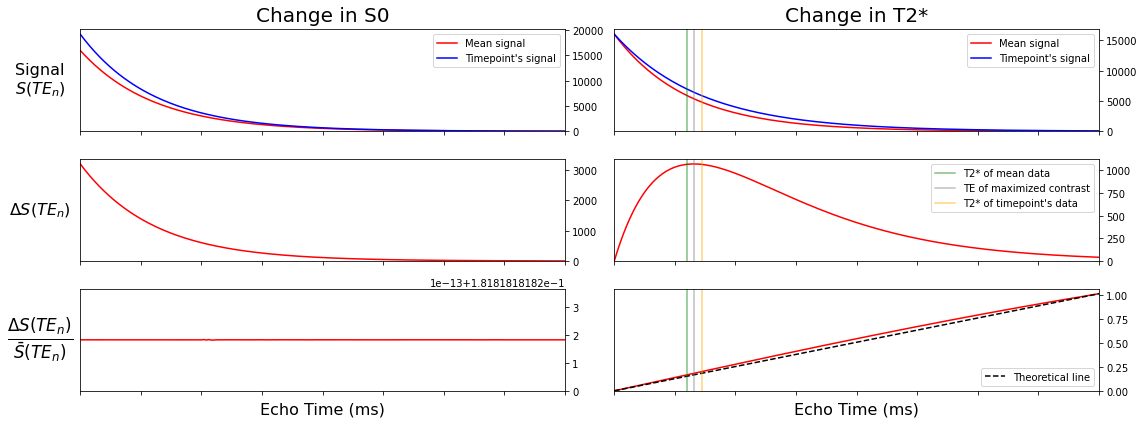

In [3]:
# change s0
fig, axes = plt.subplots(3, 2, sharex=True, figsize=(16, 6))
axes[0, 0].yaxis.tick_right()
axes[0, 0].set_xticklabels([])
axes[0, 0].plot(echo_times, mean_sig, 'red', label='Mean signal')
axes[0, 0].plot(echo_times, sig2, 'blue', label="Timepoint's signal")
axes[0, 0].set_ylim(0)
axes[0, 0].set_title('Change in S0', fontsize=20, y=1.02)
axes[0, 0].set_ylabel('Signal\n$S(TE_n)$',
                      fontsize=16, rotation=0, labelpad=40, va='center')
leg = axes[0, 0].legend()

axes[1, 0].yaxis.tick_right()
axes[1, 0].set_xticklabels([])
axes[1, 0].plot(echo_times, d_sig2, 'red')
axes[1, 0].set_ylim(0)
axes[1, 0].set_ylabel('${\\Delta}S(TE_n)$',
                      fontsize=16, rotation=0, labelpad=40, va='center')

# No slope, intercept at delta(S0)/mean(S0)
axes[2, 0].yaxis.tick_right()
axes[2, 0].plot(echo_times, dt_sig2, 'red')
axes[2, 0].set_ylabel('$\\frac{{\\Delta}S(TE_n)}{\\bar{S}(TE_n)}$',
                      fontsize=24, rotation=0, labelpad=40, va='center')
axes[2, 0].set_xlabel('Echo Time (ms)', fontsize=16)

# change t2s
# max diff is between orig and new T2*, but is definitely not mean
max_diff_te = echo_times[d_sig3 == np.max(d_sig3)][0]

axes[0, 1].yaxis.tick_right()
axes[0, 1].set_xticklabels([])
axes[0, 1].plot(echo_times, mean_sig, 'red', label='Mean signal')
axes[0, 1].plot(echo_times, sig3, 'blue', label="Timepoint's signal")
axes[0, 1].set_ylim(0)
axes[0, 1].set_title('Change in T2*', fontsize=20, y=1.02)

# Plot important echo times
axes[0, 1].axvline(mean_t2s, color='green', alpha=0.5)
axes[0, 1].axvline(max_diff_te, color='gray', alpha=0.5)
axes[0, 1].axvline(t2s2, color='orange', alpha=0.5)
leg = axes[0, 1].legend()

axes[1, 1].yaxis.tick_right()
axes[1, 1].set_xticklabels([])
axes[1, 1].plot(echo_times, d_sig3, 'red')
axes[1, 1].set_ylim(0)

# Plot important echo times
axes[1, 1].axvline(mean_t2s, label='T2* of mean data', color='green', alpha=0.5)
axes[1, 1].axvline(max_diff_te, label='TE of maximized contrast', color='gray', alpha=0.5)
axes[1, 1].axvline(t2s2, label="T2* of timepoint's data", color='orange', alpha=0.5)
leg = axes[1, 1].legend()

pred_slope = (dt_sig3[-1] - dt_sig3[0]) / (echo_times[-1] - echo_times[0])
pred_int = (pred_slope * echo_times[-1]) - dt_sig3[-1]
pred_max = pred_slope * echo_times[-1]

axes[2, 1].yaxis.tick_right()
axes[2, 1].plot(echo_times, dt_sig3, 'red')
axes[2, 1].plot([0, echo_times[-1]], [pred_int, pred_max],
                'black', linestyle='--', label='Theoretical line')
axes[2, 1].set_ylim(0, None)
axes[2, 1].set_xlim(0, np.max(echo_times))
#axes[2, 1].set_xticks(echo_times)
axes[2, 1].set_xlabel('Echo Time (ms)', fontsize=16)
axes[2, 1].axvline(max_diff_te, color='gray', alpha=0.5)
axes[2, 1].axvline(mean_t2s, color='green', alpha=0.5)
axes[2, 1].axvline(t2s2, color='orange', alpha=0.5)
leg = axes[2, 1].legend()

fig.tight_layout()
fig.show()

### Make design matrices

For TEDPCA and TEDICA, we use regression to get parameter estimates (PEs; not beta values) for component time-series against echo-specific data, and substitute those PEs for ${\bar{S}(TE_k)}$.
At some point, I would like to dig into why those parameter estimates are equivalent to ${\bar{S}(TE_k)}$ for our purposes.

### TE-independence model

```{math}
:label: te_independence_model1
\frac{{\Delta}S(TE_k)}{\bar{S(TE_k)}} = \frac{{\Delta}S_0}{S_0}
```

```{math}
:label: te_independence_model2
{\Delta}S(TE_k) = {\bar{S}(TE_k)}\frac{{\Delta}S_0}{S_0}
```

$\frac{{\Delta}S_0}{S_0}$ is a scalar (i.e., doesn't change with TE), so we ignore that,
which means we only use ${\bar{S}(TE_k)}$ (mean echo-wise signal).

Thus,

```{math}
:label: te_independence_model3
{\Delta}S(TE_k) = {\bar{S}(TE_k)} * X
```

and for TEDPCA/TEDICA,

```{math}
:label: te_independence_model4
PE(TE_k) = {\bar{S}(TE_k)} * X
```

Lastly, we fit X to the data and evaluate model fit.

### TE-dependence model

```{math}
:label: te_dependence_model1
\frac{{\Delta}S(TE_k)}{\bar{S}(TE_k)} = -{\Delta}{R_2^*}*TE_k
```

```{math}
:label: te_dependence_model2
{\Delta}S(TE_k) = {\bar{S}(TE_k)} * -{\Delta}{R_2^*}*TE_k
```

$-{\Delta}{R_2^*}$ is a scalar, so we ignore it, which means we only use ${\bar{S}(TE_k)}$ (mean echo-wise-signal) and $TE_k$ (echo time in milliseconds).

Thus,

```{math}
:label: te_dependence_model3
{\Delta}S(TE_k) = {\bar{S}(TE_k)}*TE_k * X
```

and for TEDPCA/TEDICA,

```{math}
:label: te_dependence_model4
PE(TE_k) = {\bar{S}(TE_k)}*TE_k * X
```

Lastly, we fit X to the data and evaluate model fit.

In [4]:
X1 = (mean_sig)[:, None]  # Model 1

# NOTE: T2* is unnecessary for this, since it's a scalar
X2 = ((echo_times * mean_sig) / mean_t2s)[:, None]  # Model 2

### Fitted curves for S0-perturbed signal

The predicted curve for the S0 model matches the real curve perfectly!

In [5]:
B = d_sig2[:, None]  # (E x S)
alpha = (np.abs(B)**2).sum(axis=0)

# S0 Model
coeffs_S0 = (B * X1).sum(axis=0) / (X1**2).sum(axis=0)
pred_S0 = X1 * np.tile(coeffs_S0, (n_echoes, 1))
SSE_S0 = (B - pred_S0)**2
SSE_S0 = SSE_S0.sum(axis=0)  # (S,) prediction error map
F_S0 = (alpha - SSE_S0) * (n_echoes - 1) / (SSE_S0)
pred_S0_2 = pred_S0.copy()

# R2 Model
coeffs_R2 = (B * X2).sum(axis=0) / (X2**2).sum(axis=0)
pred_R2 = X2 * np.tile(coeffs_R2, (n_echoes, 1))
SSE_R2 = (B - pred_R2)**2
SSE_R2 = SSE_R2.sum(axis=0)
F_R2 = (alpha - SSE_R2) * (n_echoes - 1) / (SSE_R2)
pred_R2_2 = pred_R2.copy()

print('Rho: {}'.format(F_S0[0]))
print('Kappa: {}'.format(F_R2[0]))
print()

# Parameter estimate * mean S0 gives delta(S0)
print('Real delta S0: {}'.format(s02 - mean_s0))
print('Delta S0 from results: {}'.format(coeffs_S0[0] * mean_s0))

Rho: 4.467769094175043e+32
Kappa: 187.14447409804956

Real delta S0: 3200.0
Delta S0 from results: 3200.000000000006


### Fitted curves for R2*-perturbed signal

For some reason, the predicted curve for the R2 model doesn't match the real signal curve.
What's with this mismatch?

It seems like the mismatch increases as the difference between the fluctuating volume's R2 and the mean R2 increase.
The fitted curve seems to actually match the mean signal, not the perturbed signal!

In [6]:
B = d_sig3[:, None]  # (E x S)
alpha = (np.abs(B)**2).sum(axis=0)

# S0 Model
coeffs_S0 = (B * X1).sum(axis=0) / (X1**2).sum(axis=0)
pred_S0 = X1 * np.tile(coeffs_S0, (n_echoes, 1))
SSE_S0 = (B - pred_S0)**2
SSE_S0 = SSE_S0.sum(axis=0)  # (S,) prediction error map
F_S0 = (alpha - SSE_S0) * (n_echoes - 1) / (SSE_S0)
pred_S0_3 = pred_S0.copy()

# R2 Model
coeffs_R2 = (B * X2).sum(axis=0) / (X2**2).sum(axis=0)
pred_R2 = X2 * np.tile(coeffs_R2, (n_echoes, 1))
SSE_R2 = (B - pred_R2)**2
SSE_R2 = SSE_R2.sum(axis=0)
F_R2 = (alpha - SSE_R2) * (n_echoes - 1) / (SSE_R2)
pred_R2_3 = pred_R2.copy()

print('Rho: {}'.format(F_S0[0]))
print('Kappa: {}'.format(F_R2[0]))

Rho: 156.88794104788448
Kappa: 31513.966302911744


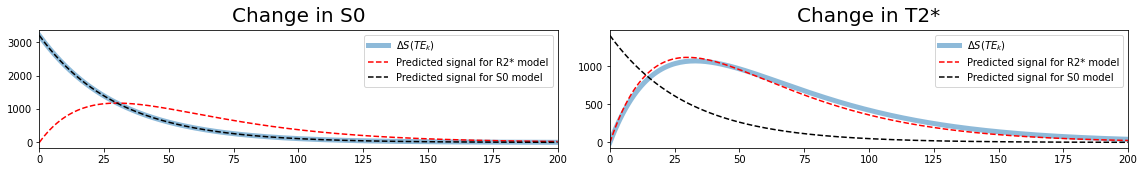

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 2.5))

axes[0].set_title('Change in S0', fontsize=20, y=1.02)
axes[0].plot(echo_times, d_sig2, label='${\\Delta}S(TE_k)$',
             linewidth=5, alpha=0.5)
axes[0].plot(echo_times, np.squeeze(pred_R2_2),
             label='Predicted signal for R2* model',
             linestyle='--', color='red')
axes[0].plot(echo_times, np.squeeze(pred_S0_2),
             label='Predicted signal for S0 model',
             linestyle='--', color='black')
axes[0].set_xlim(0, np.max(echo_times))
legend = axes[0].legend()

axes[1].set_title('Change in T2*', fontsize=20, y=1.02)
axes[1].plot(echo_times, d_sig3, label='${\\Delta}S(TE_k)$',
             linewidth=5, alpha=0.5)
axes[1].plot(echo_times, np.squeeze(pred_R2_3),
             label='Predicted signal for R2* model',
             linestyle='--', color='red')
axes[1].plot(echo_times, np.squeeze(pred_S0_3),
             label='Predicted signal for S0 model',
             linestyle='--', color='black')
axes[1].set_xlim(0, np.max(echo_times))
legend = axes[1].legend()

fig.tight_layout()
fig.show()

In [8]:
# lstsq gives same result as model fit method by kundu, which is great to see
x, res, rank, sing = np.linalg.lstsq(X2, B, rcond=None)
print(x[0])
print(coeffs_R2)

[0.19006077]
[0.19006077]


### Now let's apply this approach to components

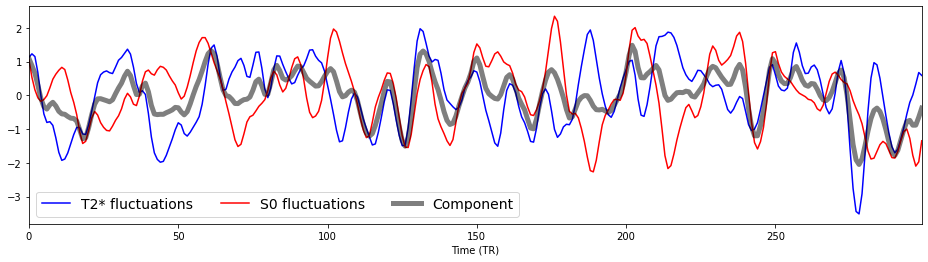

In [9]:
# Simulate data
# We'll convolve with HRF just for smoothness
hrf = first_level.spm_hrf(1, oversampling=1)

n_trs = 300

frac = 0.05  # 5% PSC
mean_t2s = 30
t2s_std = mean_t2s * frac
mean_s0 = 16000
s0_std = mean_s0 * frac

# simulate the T2*/S0 time series
t2s_ts = np.random.normal(loc=mean_t2s, scale=t2s_std, size=(n_trs+20,))
t2s_ts = signal.convolve(t2s_ts, hrf)[20:n_trs+20]
t2s_ts *= t2s_std / np.std(t2s_ts)
t2s_ts += mean_t2s - np.mean(t2s_ts)

s0_ts = np.random.normal(loc=mean_s0, scale=s0_std, size=(n_trs+20,))
s0_ts = signal.convolve(s0_ts, hrf)[20:n_trs+20]
s0_ts *= s0_std / np.std(s0_ts)
s0_ts += mean_s0 - np.mean(s0_ts)

# Constant T2*/S0 time series
mean_s0_ts = np.ones(n_trs) * mean_s0
mean_t2s_ts = np.ones(n_trs) * mean_t2s

# Simulate signal for each echo time
t2s_signal = predict_bold_signal(echo_times, mean_s0_ts, t2s_ts)
s0_signal = predict_bold_signal(echo_times, s0_ts, mean_t2s_ts)
multiecho_signal = predict_bold_signal(echo_times, s0_ts, t2s_ts)

# Normalize to get component time series
t2s_ts_z = stats.zscore(t2s_ts)
s0_ts_z = stats.zscore(s0_ts)
p = 0.5  # proportion for combination
component = (p * t2s_ts_z) + ((1 - p) * s0_ts_z)

fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(t2s_ts_z, label='T2* fluctuations', color='blue')
ax.plot(s0_ts_z, label='S0 fluctuations', color='red')
ax.plot(component, label='Component', color='black', alpha=0.5, linewidth=5)
ax.set_xlim(0, n_trs-1)
ax.set_xlabel('Time (TR)')
leg = ax.legend(fontsize=14, ncol=3)
fig.show()

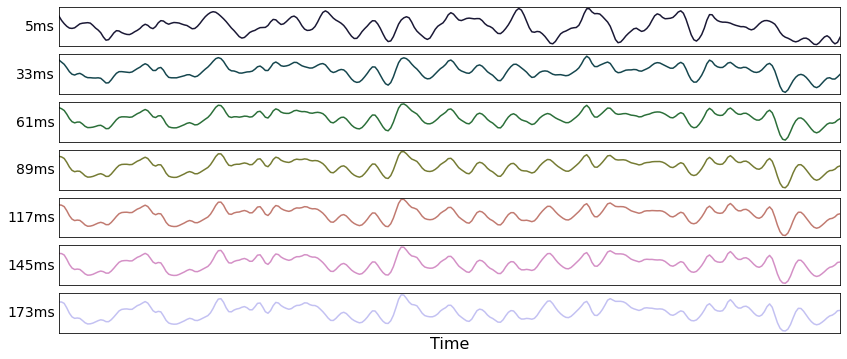

In [10]:
interval = int(np.floor(n_echoes / 7))
echoes_to_plot = list(range(5, n_echoes, interval))
fig, axes = plt.subplots(len(echoes_to_plot), sharex=True, sharey=False, figsize=(14, 6))

for i_echo, echo in enumerate(echoes_to_plot):
    axes[i_echo].plot(multiecho_signal[echo, :], color=pal[i_echo])
    axes[i_echo].set_ylabel('{0}ms'.format(echo_times[echo]), rotation=0, va='center', ha='right', fontsize=14)
    axes[i_echo].set_yticks([])
    axes[i_echo].set_xticks([])

axes[-1].set_xlabel('Time', fontsize=16)
axes[-1].set_xlim(0, n_trs-1)
#fig.tight_layout()
fig.show()

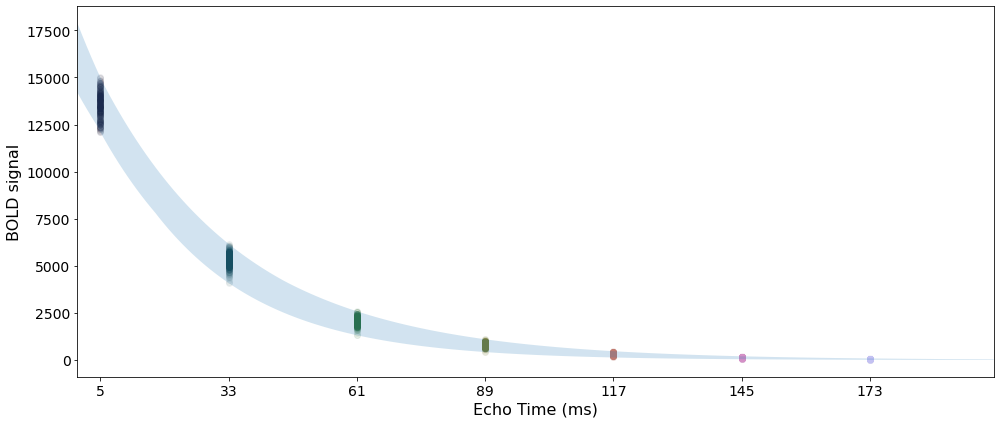

In [11]:
interval = int(np.floor(n_echoes / 7))
echoes_to_plot = list(range(5, n_echoes, interval))
fig, ax = plt.subplots(figsize=(14, 6))
for i_echo, echo in enumerate(echoes_to_plot):
    rep_echo_times = np.ones(n_trs) * echo
    ax.scatter(rep_echo_times, multiecho_signal[echo, :], alpha=0.05, color=pal[i_echo])

max_signal = np.max(multiecho_signal, axis=1)
min_signal = np.min(multiecho_signal, axis=1)
ax.fill_between(echo_times, max_signal, min_signal, alpha=0.2)

ax.set_ylabel('BOLD signal', fontsize=16)
ax.set_xlabel('Echo Time (ms)', fontsize=16)
ax.set_xticks(echoes_to_plot)
ax.set_xlim(0, np.max(echo_times))
ax.tick_params(axis='both', which='major', labelsize=14)
fig.tight_layout()
fig.show()

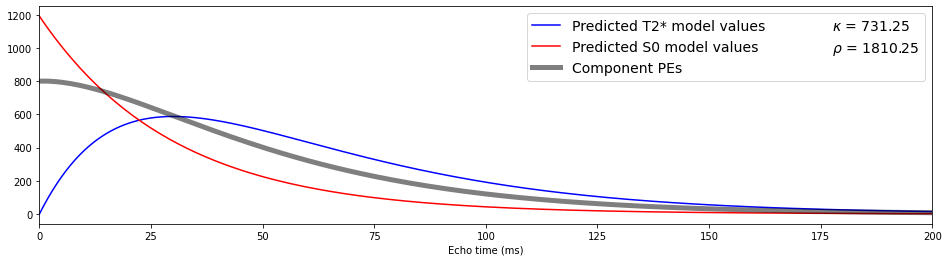

In [12]:
fig, ax = plt.subplots(figsize=(16, 4))

# Add a constant term to the array
comp_X = np.hstack((component[:, None], np.ones((component.shape[0], 1))))
pes, _, _, _ = np.linalg.lstsq(comp_X, multiecho_signal.T, rcond=None)
pes = pes[0, :]

F_S0, F_R2, pred_S0, pred_R2 = compute_te_dependence_statistics(multiecho_signal, pes, echo_times)
ax.plot(echo_times, pred_R2, label='Predicted T2* model values', c='blue')
ax.plot(echo_times, pred_S0, label='Predicted S0 model values', c='red')
ax.plot(echo_times, pes, label='Component PEs', alpha=0.5, linewidth=5, c='black')
ax.plot(echo_times, pred_R2, label=r'$\kappa$ = {:.02f}'.format(F_R2[0]), alpha=0)
ax.plot(echo_times, pred_S0, label=r'$\rho$ = {:.02f}'.format(F_S0[0]), alpha=0)
ax.set_xlim(0, np.max(echo_times))
ax.set_xlabel('Echo time (ms)')
leg = ax.legend(fontsize=14, ncol=2)
#ax.set_xticks(echo_times)
fig.show()